In [1]:
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#load the spectrograms
data_spec = np.load("/content/drive/My Drive/Colab Notebooks/Cópia de Copy of Data_Spectrograms.pkl", allow_pickle = True)
x, y = data_spec

In [3]:

#split into testing and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)



(array([2569.,    0., 2198.,    0., 2535.,    0., 2153.,    0., 1954.,
        1659.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

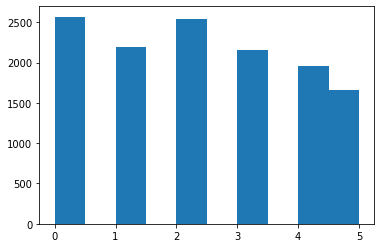

In [4]:
#check distribution of classes
plt.hist(y_train)

In [5]:
#oversample the minority class using ADASYN
from imblearn.over_sampling import SMOTE , ADASYN
from imblearn.under_sampling import RandomUnderSampler

# These tools only work with 2D data, needed to reshape before using and reshaping again after it
X_train=X_train.reshape(X_train.shape[0],6000)

# create synthetic samples for the minority class
sm = ADASYN(sampling_strategy='minority')         
X_train, y_train = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(14045,)
(2307,)


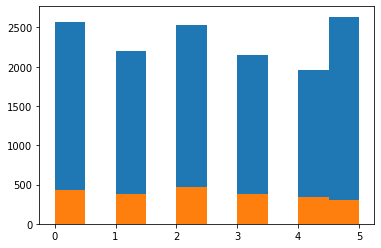

In [6]:

#check the new distribution of y_train, as well as the distribution of y_test
plt.hist(y_train)
print(y_train.shape)
plt.hist(y_test)
print(y_test.shape)

In [7]:
#reshape the spectrograms to fit the model architecture
X_train = X_train.reshape(X_train.shape[0], 30, 100, 2)
X_test = X_test.reshape(X_test.shape[0], 30, 100, 2)


In [8]:
#use to_categorical to create categorical vectors out of the integer targets
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [9]:
#create and compile the model
from keras.layers import Dense, GRU, Input, LSTM, Bidirectional, Dropout, Activation, Conv1D, Conv2D, concatenate, SimpleRNN
from keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling2D, AveragePooling1D, Flatten, Add, Reshape, RepeatVector
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import backend as K
from keras import metrics

In [10]:
def create_model(n_cnn_dense=64, drop=True, input_dim=2, timesteps=3000, fs=100, num_classes=6):
    
    input_dim = input_dim
    timesteps = timesteps   
    inp = Input(shape=(timesteps, input_dim))
    inp2 = Input(shape=(30,100,2))
    fs = fs
    num_classes = num_classes
    #84,57
    x = (Conv2D(filters=32, kernel_size=(5,5), activation='tanh', padding='same', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))(inp2)
    x = (Conv2D(filters=32, kernel_size=(3,3), activation='tanh',padding='valid'))(x)
    x = (Conv2D(filters=32, kernel_size=(3,3), activation='tanh',padding='valid'))(x)
    x = MaxPooling2D(pool_size=(2,2), strides=1, padding='same')(x)
    if drop:
        x = Dropout(0.2)(x)
    
    y = Conv2D(filters=64, kernel_size=(100,100), strides=1,  activation='tanh', padding='same', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01))(inp2)
    y = (Conv2D(filters=32, kernel_size=(3,3), activation='tanh',padding='same'))(y)
    y = (Conv2D(filters=32, kernel_size=(3,3), activation='tanh',padding='same'))(y)
    y = (Conv2D(filters=32, kernel_size=(3,3), activation='tanh',padding='valid'))(y)
    y = (Conv2D(filters=128, kernel_size=(3,3), activation='tanh',padding='valid'))(y)
    y = (Conv2D(filters=32, kernel_size=(3,3), activation='tanh',padding='same'))(y)
    
    xy = concatenate([x, y], axis=3)        
    output = Dense(n_cnn_dense, activation='relu')(xy)
    pool_size = int(output.shape[1]) // 4
    output = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding='valid')(output)
    output = Flatten()(output)
    output = RepeatVector(2)(output)
    output = SimpleRNN(100,activation='relu', kernel_initializer='glorot_uniform')(output)     
    output = Dense(num_classes, activation='softmax')(output)
    
    model = Model(inputs=inp2, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
# Remove warnings
import logging
logging.getLogger('tensorflow').disabled = True 

#create model and model summary
model = create_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 100, 2)] 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 30, 100, 64)  1280064     input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 100, 32)  1632        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 30, 100, 32)  18464       conv2d_3[0][0]                   
_______________________________________________________________________________________

In [12]:
#fit the model on the train data, validate on test data
#use ModelCheckpoint to save the best performing model on validation accuracy
from keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True) 

model.fit(X_train, y_train,  validation_data=(X_test,y_test), verbose=1, batch_size=256, epochs= 50,callbacks= [mc])


# load the saved model
from keras.models import load_model
saved_model = load_model('best_model.h5')

Epoch 1/50
55/55 [==============================] - 98s 2s/step - loss: 2.5514 - accuracy: 0.4873 - val_loss: 1.8886 - val_accuracy: 0.6121
Epoch 2/50
55/55 [==============================] - 97s 2s/step - loss: 1.6199 - accuracy: 0.6922 - val_loss: 1.4891 - val_accuracy: 0.7243
Epoch 3/50
55/55 [==============================] - 96s 2s/step - loss: 1.4014 - accuracy: 0.7350 - val_loss: 1.3250 - val_accuracy: 0.7646
Epoch 4/50
55/55 [==============================] - 96s 2s/step - loss: 1.2819 - accuracy: 0.7598 - val_loss: 1.2461 - val_accuracy: 0.7698
Epoch 5/50
55/55 [==============================] - 96s 2s/step - loss: 1.2197 - accuracy: 0.7726 - val_loss: 1.1989 - val_accuracy: 0.7824
Epoch 6/50
55/55 [==============================] - 96s 2s/step - loss: 1.1705 - accuracy: 0.7818 - val_loss: 1.1960 - val_accuracy: 0.7750
Epoch 7/50
55/55 [==============================] - 96s 2s/step - loss: 1.1260 - accuracy: 0.7974 - val_loss: 1.1601 - val_accuracy: 0.7893
Epoch 8/50
55/55 [==

OSError: ignored

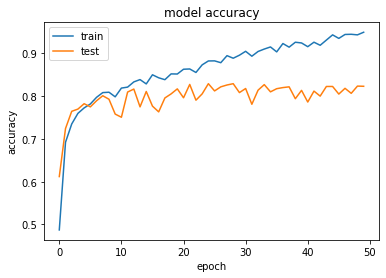

In [13]:
#Plotting accuracy during training

import matplotlib.pyplot as plt
plt.plot(model.history.history["accuracy"])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# get training and testing accuracy
score = model.evaluate(X_train, y_train, verbose=1)
print("Training Accuracy: ", score[1])
score = model.evaluate(X_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

439/439 [==============================] - 13s 30ms/step - loss: 0.8748 - accuracy: 0.9657
Training Accuracy:  0.9656817317008972
73/73 [==============================] - 2s 29ms/step - loss: 1.3095 - accuracy: 0.8231
Testing Accuracy:  0.8231469392776489


In [ ]:
#load testing set and reshape to right dimensions
test = np.load("/content/drive/My Drive/Deep Learning/Test_Spectrograms_no_labels.pkl", allow_pickle = True)
test = np.array(test)
test = test.reshape(1754, 30, 100, 2)

In [ ]:
#generate predictions using our saved model
#use argmax to turn categorical vectors back into integer predictions
#save to a .txt file
predictions = saved_model.predict(test)
predictions = np.argmax(predictions, axis = 1)
np.savetxt("predictions19.txt", predictions, fmt='%i', encoding = None)
